In [4]:
from scipy.optimize import curve_fit
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
import functools
from loguru import logger
from GEN_Utils import FileHandling

logger.info('Import OK')

output_folder = 'results/'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

2022-01-21 14:11:56,964 GEN_Utils.FileHandling: [INFO ]  Import ok
2022-01-21 14:11:56.965 | INFO     | __main__:<module>:13 - Import OK


In [5]:
def gauss(x, H, A, mean, sigma):
    return H + A * np.exp(-(x - mean) ** 2 / (2 * sigma ** 2))

def fit_gauss(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return popt

def plot_gauss(xdata, ydata):
    popt = fit_gauss(xdata, ydata)
    xfit = np.arange(np.min(xdata), np.max(xdata),
    (np.max(xdata) - np.min(xdata))/1000)
    fig, ax = plt.subplots()
    plt.plot(xdata, ydata, 'ko', label='data')
    plt.plot(xfit, gauss(xfit, *popt), '--r', label='fit')
    ax.axvline(popt[2])
    plt.show()
    return popt

def peak_maker(peak_dict, x_range=(0, 50), precision=0.1, noise=0.05, visualise=False):
    x0, x1 = x_range
    peaks = []
    for peak, (H, A, mean, sigma) in peak_dict.items():
        peak_vals = pd.DataFrame([np.arange(x0, x1, precision), gauss(
        np.arange(x0, x1, precision), H=H, A=A, mean=mean, sigma=sigma)], index=['x', 'y']).T
        peak_vals['y'] = peak_vals['y'] + \
        np.random.uniform(0, noise, len(peak_vals))
        peaks.append(peak_vals)
        peaks = pd.concat(peaks).groupby('x').sum().reset_index()
    if visualise:
        sns.lineplot(
        data=peaks,
        x='x',
        y='y')
        plt.show()
    return peaks


def plot_peaks(dfs, labels, colors, separate=True, combined=False, max_val=None):
    for label, df_list in dfs.items():
        if separate:
            fig, axes = plt.subplots(
            1, len(df_list), figsize=(len(df_list)*6, 5), squeeze=False)
            for x, df in enumerate(df_list):
                ax = axes[0][x]
                sns.lineplot(
                data=df,
                x='x',
                y='y',
                color=colors[x],
                ax=ax,
                )
                ax.xaxis.set_minor_locator(AutoMinorLocator())
                ax.set_ylabel(ylabels[x])
                ax.set_xlabel('Fraction')
                if max_val:
                    ax.set_ylim(0, max_val)
                plt.savefig(f'{output_folder}panels_{label}.png')
                plt.show()
        if combined:
            fig, ax = plt.subplots(figsize=(6, 5))
            sns.lineplot(
            data=df_list[0],
            x='x',
            y='y',
            color=colors[0])
            plt.xlabel('Fraction')
            plt.ylabel(labels[0], color=colors[0])
            plt.yticks(color=colors[0])
            if max_val:
                ax.set_ylim(0, max_val)
            
            ax2 = ax.twinx()
            sns.lineplot(
            data=df_list[1],
            x='x',
            y='y',
            color=colors[1],
            linestyle='--',
            ax=ax2)
            if max_val:
                ax2.set_ylim(0, max_val)
            plt.ylabel(labels[1], color=colors[1], rotation=-90, va='bottom')
            plt.yticks(color=colors[1])
            plt.savefig(f'{output_folder}combined_{label}.png')
            plt.show()

In [7]:
peaks = {
1: [0, 1.4, 15, 2.5],
}
large = peak_maker(peaks)

In [8]:
peaks = {
1: [0, 0.6, 15, 2.5],
}
small = peak_maker(peaks)

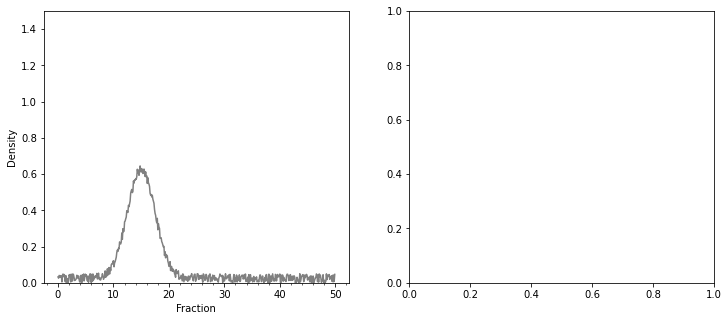

<Figure size 432x288 with 0 Axes>

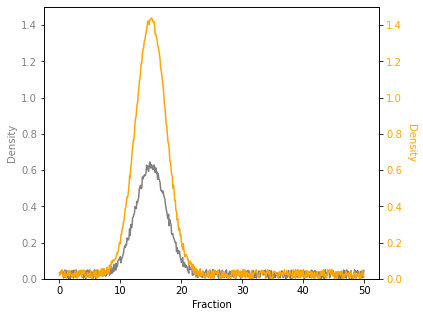

In [9]:
dfs = {
'combined': [small, large],
}
ylabels = ['Density', 'Density']
colors = ['grey', 'orange']
plot_peaks(dfs, ylabels, colors, combined=True, max_val=1.5)

In [10]:
merged_df = functools.reduce(lambda left, right: pd.merge(
left, right, on='x', how='outer', suffixes=['_small', '_large']), [small, large])
merged_df.to_csv('simulated_data.csv')

In [11]:
merged_df

,x,y_small,y_large
0,0.0,0.032525,0.019461
1,0.1,0.025456,0.033949
2,0.2,0.040628,0.029459
3,0.3,0.038966,0.036791
4,0.4,0.030251,0.049689
...,...,...,...
495,49.5,0.041433,0.009958
496,49.6,0.005161,0.031710
497,49.7,0.042880,0.046747
498,49.8,0.007131,0.024235


In [12]:
import os, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lmfit import models
import scipy.integrate as integrate
import functools
import math
from loguru import logger

logger.info('Import OK')

input_path = 'simulated_data.csv'

# Read in simulated data
data = pd.read_csv(input_path)
data.drop([col for col in data.columns.tolist() if 'Unnamed: ' in col], axis=1, inplace=True)

xvals = data['x'].tolist()
xfit = np.arange(0, 50, 0.1)

2022-01-21 14:12:26.878 | INFO     | __main__:<module>:12 - Import OK


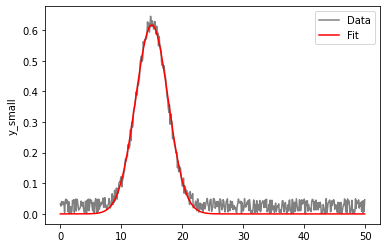

In [13]:
model_small = models.GaussianModel()
params = model_small.make_params(center=15, sigma=0.4, amplitude=0.6)
output_small = model_small.fit(data['y_small'].tolist(), params=params, x=xvals)
# output_small.plot()

fit_small = model_small.eval(x=xfit, params=output_small.params)

fig, ax = plt.subplots()
sns.lineplot(
    x=xvals,
    y=data['y_small'],
    label='Data',
    color='grey')
sns.lineplot(
    x=xfit,
    y=fit_small,
    label='Fit',
    color='red')    
plt.show()

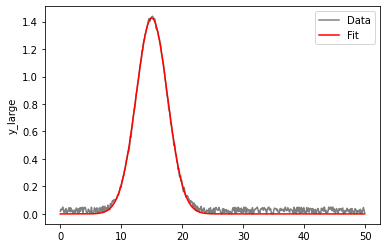

In [14]:
model_large = models.GaussianModel()
model_large.make_params(center=15, sigma=0.4, amplitude=1.4)
output_large = model_large.fit(
data['y_large'].tolist(), params=params, x=xvals)
# output_large.plot()

fit_large = model_large.eval(x=xfit, params=output_large.params)

fig, ax = plt.subplots()
sns.lineplot(
    x=xvals,
    y=data['y_large'],
    label='Data',
    color='grey')
sns.lineplot(
    x=xfit,
    y=fit_large,
    label='Fit',
    color='red')
plt.show()

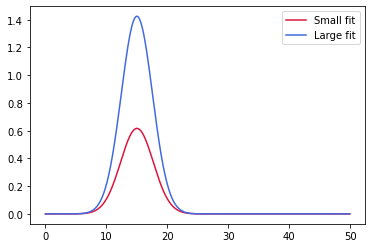

In [15]:
fig, ax = plt.subplots()
sns.lineplot(
    x=xfit,
    y=fit_small,
    label='Small fit',
    color='crimson')
sns.lineplot(
    x=xfit,
    y=fit_large,
    label='Large fit',
    color='royalblue')
plt.show()

In [16]:
lower_bound = 0
upper_bound = 50

# Define the gaussian model equation in machine-readable format
def generic_gauss(A, centre, sigma, x): #note partial below is positional, so x MUST go last here, although normally it would be first
    return (A / (sigma * np.sqrt((2*math.pi)))) * np.exp((-(x-centre)**2) / (2*sigma**2))
# A 'wrapper' function, which produces a partially complete version of the gauss func leaving only x to be specified
def create_gauss(A, centre, sigma):
    return functools.partial(generic_gauss, A, centre, sigma)
# Create a partially-filled version of the gaussian function using the fitted paramters
small_func = create_gauss(
A=output_small.params['amplitude'].value,
centre=output_small.params['center'].value,
sigma=output_small.params['sigma'].value,
)
# calculate integral
integral, error = integrate.quad(small_func, lower_bound, upper_bound)
large_func = create_gauss(
A=output_large.params['amplitude'].value,
centre=output_large.params['center'].value,
sigma=output_large.params['sigma'].value,
)
# calculate integral
integral, error = integrate.quad(small_func, lower_bound, upper_bound)
logger.info(f'Area under curve small is {integral}')
integral, error = integrate.quad(large_func, lower_bound, upper_bound)
logger.info(f'Area under the large curve is {integral}')

2022-01-21 14:13:23.993 | INFO     | __main__:<module>:25 - Area under curve small is 4.136059444543434
2022-01-21 14:13:23.995 | INFO     | __main__:<module>:27 - Area under the large curve is 9.148631293473933
